In [3]:
# 06_model_interpretation.ipynb

import os, glob, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import shap

# --- Create output dir for interpretation ---
OUT_DIR = "../interpretation"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Load prepared data ---
DATA_DIR = "../preprocessed_tabular_data"
train = pd.read_csv(os.path.join(DATA_DIR, "train_prepared.csv"))



In [4]:
X = train.drop(columns=["label", "tic_id", "obj_id", "object_name", "star_name"], errors="ignore")
y = train["label"]
X = X.select_dtypes(include=[np.number])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Load all saved models ---
model_files = glob.glob("../models/*.pkl")
models = {os.path.basename(f).replace(".pkl",""): joblib.load(f) for f in model_files}

print("Loaded models:", list(models.keys()))


Loaded models: ['01_RandomForest', '02_GradientBoosting', '03_AdaBoost']


In [5]:

# --- 1. Evaluation metrics for all models ---
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    
    results.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_df.to_csv(os.path.join(OUT_DIR, "interpretation_metrics.csv"), index=False)
print("✅ Metrics saved:", os.path.join(OUT_DIR, "interpretation_metrics.csv"))
display(results_df)

✅ Metrics saved: ../interpretation\interpretation_metrics.csv


,model,accuracy,precision,recall,f1,roc_auc
0,01_RandomForest,0.983929,0.974937,1.000000,0.987310,0.999523
1,02_GradientBoosting,0.859783,0.848240,0.944730,0.893889,0.928054
2,03_AdaBoost,0.832061,0.817522,0.941517,0.875149,0.899351



🔎 Permutation Importance for 01_RandomForest


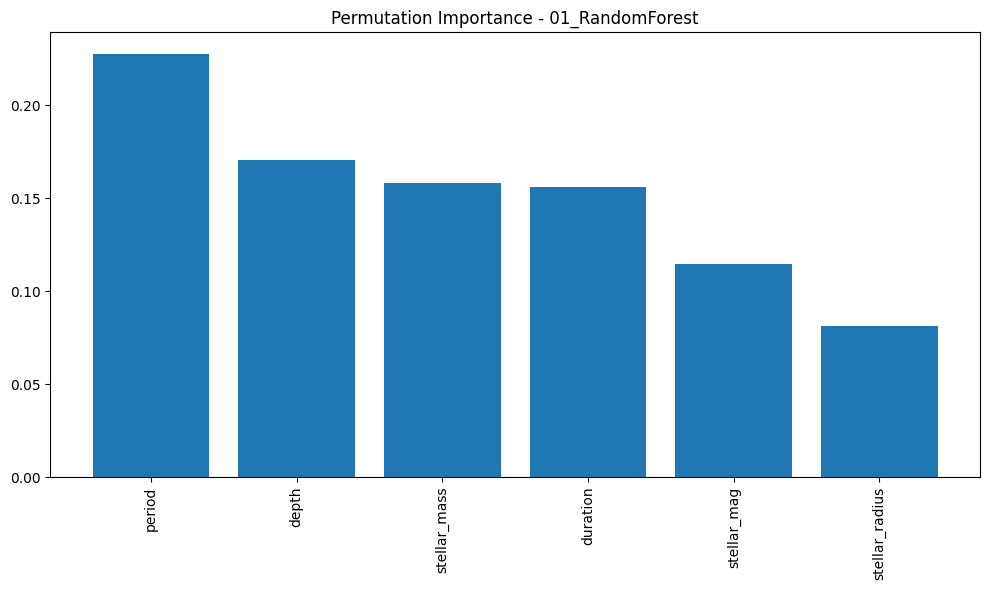

✅ Saved: ../interpretation\01_RandomForest_perm_importance.png

🔎 Permutation Importance for 02_GradientBoosting


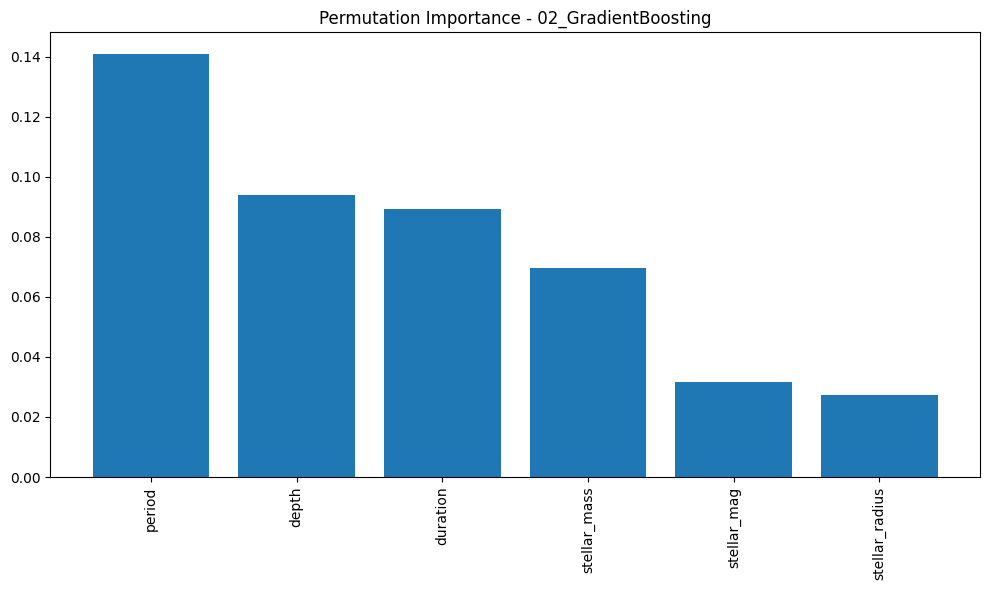

✅ Saved: ../interpretation\02_GradientBoosting_perm_importance.png

🔎 Permutation Importance for 03_AdaBoost


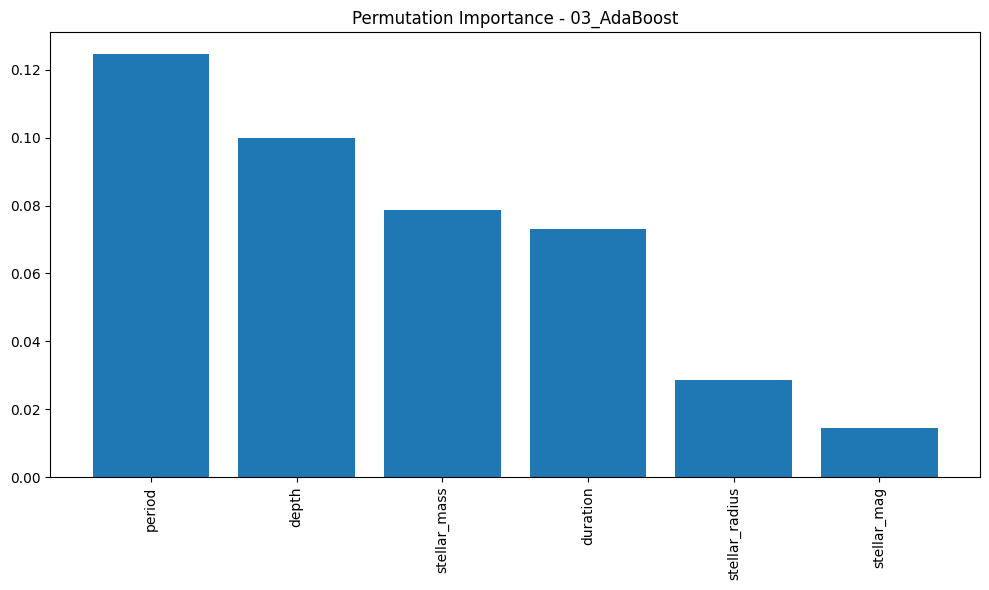

✅ Saved: ../interpretation\03_AdaBoost_perm_importance.png


In [6]:
# --- 2. Permutation Importance ---
for name, model in models.items():
    print(f"\n🔎 Permutation Importance for {name}")
    perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = perm.importances_mean.argsort()[::-1]
    
    plt.figure(figsize=(10,6))
    plt.bar(range(len(sorted_idx)), perm.importances_mean[sorted_idx])
    plt.xticks(range(len(sorted_idx)), X.columns[sorted_idx], rotation=90)
    plt.title(f"Permutation Importance - {name}")
    plt.tight_layout()
    
    save_path = os.path.join(OUT_DIR, f"{name}_perm_importance.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved: {save_path}")

In [7]:
# --- 3. SHAP Analysis ---
for name, model in models.items():
    print(f"\n🔎 SHAP Summary for {name}")
    try:
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        
        # Summary plot
        shap.summary_plot(shap_values, X_test, show=False, max_display=15)
        save_path = os.path.join(OUT_DIR, f"{name}_shap_summary.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Saved: {save_path}")
        
        # Dependence plot for top feature
        top_feature = X.columns[sorted_idx[0]]
        shap.dependence_plot(top_feature, shap_values.values, X_test, show=False)
        save_path = os.path.join(OUT_DIR, f"{name}_shap_dependence_{top_feature}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Saved: {save_path}")
        
    except Exception as e:
        print(f"⚠️ SHAP not supported for {name}: {e}")



🔎 SHAP Summary for 01_RandomForest


100%|===================| 4976/4978 [36:05<00:00]        

✅ Saved: ../interpretation\01_RandomForest_shap_summary.png
⚠️ SHAP not supported for 01_RandomForest: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 50

🔎 SHAP Summary for 02_GradientBoosting
⚠️ SHAP not supported for 02_GradientBoosting: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.331787, while the model output was 0.250950. If this difference is acceptable you can set check_additivity=False to disable this check.

🔎 SHAP Summary for 03_AdaBoost
⚠️ SHAP not supported for 03_AdaBoost: The passed model is not callable and cannot be analyzed directly with the given masker! Model: AdaBoostClassifier(estimator=Decisi


🔎 PDP for 01_RandomForest


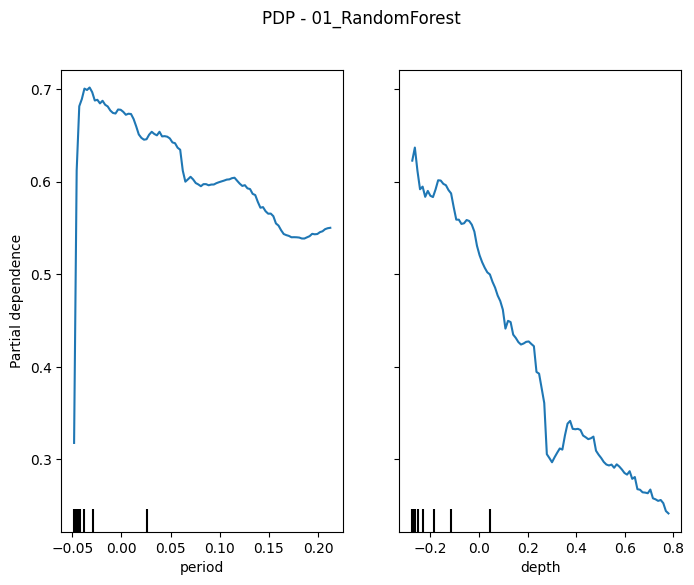

✅ Saved: ../interpretation\01_RandomForest_pdp.png

🔎 PDP for 02_GradientBoosting


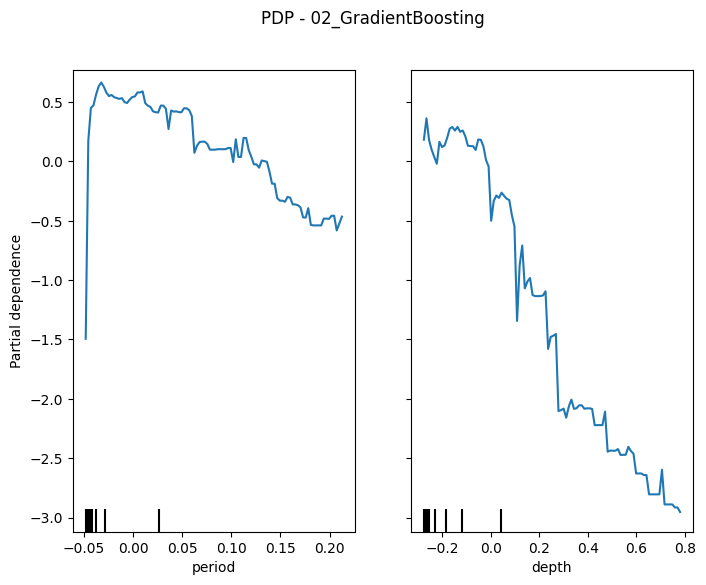

✅ Saved: ../interpretation\02_GradientBoosting_pdp.png

🔎 PDP for 03_AdaBoost


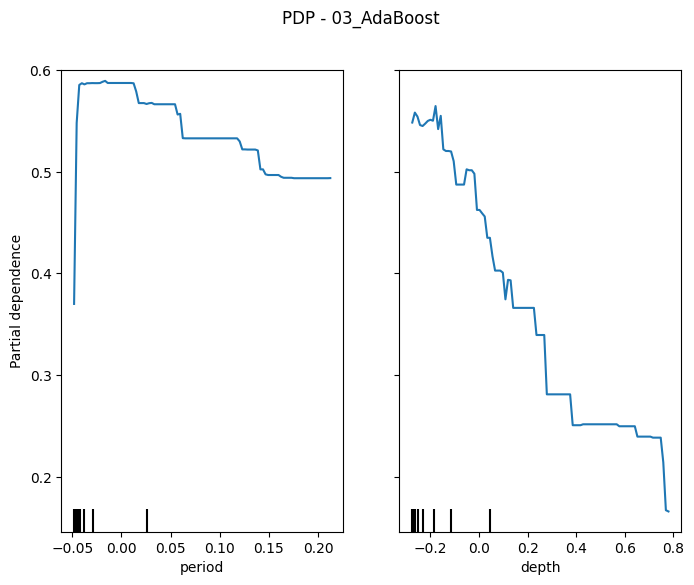

✅ Saved: ../interpretation\03_AdaBoost_pdp.png


In [8]:
# --- 4. Partial Dependence Plots ---
for name, model in models.items():
    print(f"\n🔎 PDP for {name}")
    try:
        top_features = [X.columns[i] for i in sorted_idx[:2]]
        fig, ax = plt.subplots(figsize=(8,6))
        PartialDependenceDisplay.from_estimator(model, X_test, top_features, kind="average", ax=ax)
        plt.suptitle(f"PDP - {name}")
        
        save_path = os.path.join(OUT_DIR, f"{name}_pdp.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.show()
        print(f"✅ Saved: {save_path}")
    except Exception as e:
        print(f"⚠️ PDP not supported for {name}: {e}")


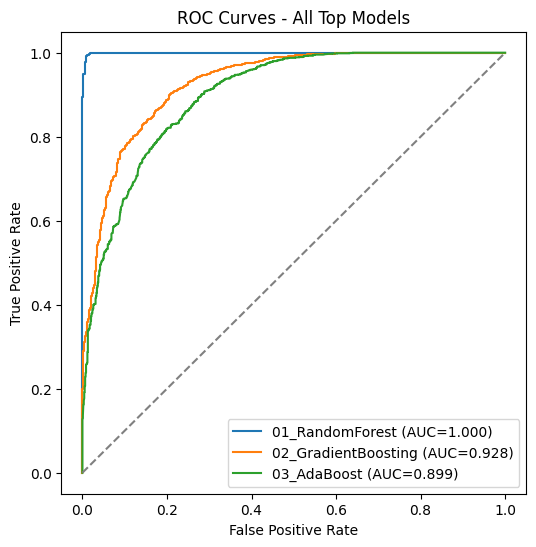

✅ Saved: ../interpretation\roc_curves.png


In [9]:
# --- 5. ROC Curves for all models ---
plt.figure(figsize=(6,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.3f})")

plt.plot([0,1],[0,1], "--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Top Models")
plt.legend()

save_path = os.path.join(OUT_DIR, "roc_curves.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"✅ Saved: {save_path}")

In [10]:
# --- 6. Generate Markdown Report ---

report_path = os.path.join(OUT_DIR, "report.md")

with open(report_path, "w") as f:
    f.write("# Model Interpretation Report\n\n")
    f.write("This report summarizes the performance and interpretability analyses of the top models.\n\n")

    # Metrics Table
    f.write("## Metrics Summary\n\n")
    f.write(results_df.to_markdown(index=False))
    f.write("\n\n")

    # Plots
    f.write("## ROC Curves\n\n")
    f.write("![ROC Curves](roc_curves.png)\n\n")

    for name in models.keys():
        f.write(f"## {name}\n\n")

        # Permutation importance
        f.write("### Permutation Importance\n\n")
        f.write(f"![{name} Permutation Importance]({name}_perm_importance.png)\n\n")

        # SHAP
        shap_summary = os.path.join(OUT_DIR, f"{name}_shap_summary.png")
        if os.path.exists(shap_summary):
            f.write("### SHAP Summary Plot\n\n")
            f.write(f"![{name} SHAP Summary]({os.path.basename(shap_summary)})\n\n")

        shap_dep = [p for p in os.listdir(OUT_DIR) if p.startswith(f"{name}_shap_dependence")]
        if shap_dep:
            f.write("### SHAP Dependence Plot\n\n")
            f.write(f"![{name} SHAP Dependence]({shap_dep[0]})\n\n")

        # PDP
        pdp_path = os.path.join(OUT_DIR, f"{name}_pdp.png")
        if os.path.exists(pdp_path):
            f.write("### Partial Dependence Plot\n\n")
            f.write(f"![{name} PDP]({os.path.basename(pdp_path)})\n\n")

print(f"✅ Markdown report saved: {report_path}")


✅ Markdown report saved: ../interpretation\report.md
